Simple example how use PyTorch to solving segmentation problem 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

In [2]:
path = '../input/'

In [3]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [6]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

In [7]:
data_transf = transforms.Compose([
                                  transforms.Scale((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=16)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:209: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


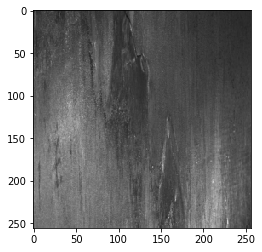

In [8]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

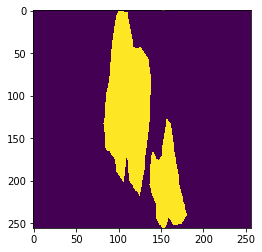

In [9]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

In [10]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [11]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:            
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError()

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError()

        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        return x

In [13]:
class BCELoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)

In [14]:
model = UNet().cuda()

criterion = BCELoss2d().cuda()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.0001, momentum=0.9)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [15]:
%%time
# Train model
loss_log=[]
for epoch in range(3):    
    model.train()        
    for ii, (data, target) in enumerate(train_loader):  
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)                    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()          
        if ii % 1000 == 0:
            loss_log.append(loss.item())       
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 - Loss: 0.201903
Epoch: 2 - Loss: 0.037414
Epoch: 3 - Loss: 0.017792
CPU times: user 5min 29s, sys: 2min 54s, total: 8min 23s
Wall time: 8min 30s


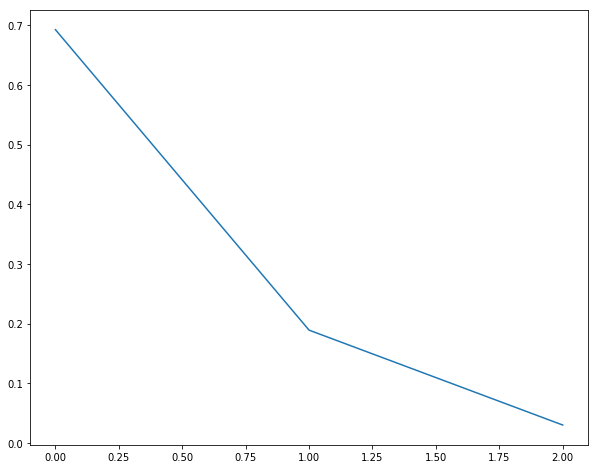

In [16]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

In [17]:
submit = pd.read_csv(path + 'sample_submission.csv')

test_data = ImageData(df = submit, transform = data_transf, subset="test")
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [18]:
%%time
# Prediction
predict = []
model.eval()
for data in test_loader:
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy()    
    predict.append(output[0] * -1)

CPU times: user 1min 28s, sys: 1min 1s, total: 2min 30s
Wall time: 2min 31s


In [19]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [20]:
%%time
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

CPU times: user 1h 4min 9s, sys: 2.7 s, total: 1h 4min 12s
Wall time: 1h 4min 2s


In [21]:
submit['EncodedPixels'] = pred_rle

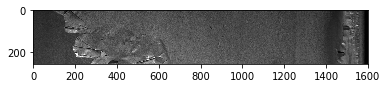

In [22]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

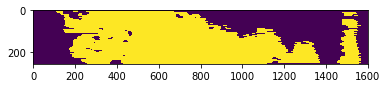

In [23]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [24]:
submit.head(10)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,769 254 1025 254 1281 254 1537 254 1793 254 20...
1,004f40c73.jpg_2,769 254 1025 254 1281 254 1537 254 1793 254 20...
2,004f40c73.jpg_3,769 254 1025 254 1281 254 1537 254 1793 254 20...
3,004f40c73.jpg_4,769 254 1025 254 1281 254 1537 254 1793 254 20...
4,006f39c41.jpg_1,4302 1 4558 1 4814 1 5070 1 5326 1 5582 1 5834...
5,006f39c41.jpg_2,4302 1 4558 1 4814 1 5070 1 5326 1 5582 1 5834...
6,006f39c41.jpg_3,4302 1 4558 1 4814 1 5070 1 5326 1 5582 1 5834...
7,006f39c41.jpg_4,4302 1 4558 1 4814 1 5070 1 5326 1 5582 1 5834...
8,00b7fb703.jpg_1,2441 116 2697 116 2953 116 3209 116 3465 116 3...
9,00b7fb703.jpg_2,2441 116 2697 116 2953 116 3209 116 3465 116 3...


In [25]:
submit.to_csv('submission.csv', index=False)